In [77]:
import pandas as pd
import os
import re
import numpy as np
import pandas_profiling
import gc
import json
from tqdm import tqdm 
from edm import report
import collections 
from collections import Counter

#NLTK
import nltk
from nltk.corpus import stopwords
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.util import ngrams

# spaCy based imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
eng_stopwords = STOP_WORDS


#Etc
import matplotlib.pyplot as plt 
import seaborn as sns
import time
import operator 

pd.set_option('max_colwidth',400)

## You can load any data set and define the column name 

In [2]:
os.chdir("/Users/dsg281/RahulData/Play_Area/Socail_NLP_2019/2019_Data/Combind_data_csv")

In [3]:
EmotionPush_train = pd.read_excel("EmotionPush_train.xlsx")
EmotionPush_Augmented_train = pd.read_excel("EmotionPush_Augmented_train.xlsx")
Friends_train = pd.read_excel("Friends_train.xlsx")
Friends_Augmented_train = pd.read_excel("Friends_Augmented_train.xlsx")

In [4]:
### Combine all data

In [5]:
data1 = EmotionPush_Augmented_train[['utterance','emotion']]
data2 = EmotionPush_train[['utterance','emotion']]
data3 = Friends_Augmented_train[['utterance','emotion']]
data4 = Friends_train[['utterance','emotion']]
df = pd.concat([data1,data2,data3,data4],names=['utternace','emotion'])


In [6]:
df = pd.DataFrame(df,columns=['utterance','emotion'])

In [7]:
Emotion_full = pd.concat([data1,data2],names=['utternace','emotion'])
Friends_full = pd.concat([data3,data4],names=['utternace','emotion'])

### Exploratory data analysis

In [8]:
df = pd.DataFrame(Emotion_full)

In [9]:
df.head()

,utterance,emotion
0,Sorry to bother you but do you have the 270 textbook?,neutral
1,What's it called,neutral
2,Digital design and principles I think,neutral
3,I don't think so?,neutral
4,I could be wrong,neutral


In [10]:
df['utterance'] = df['utterance'].astype(str)
df['emotion'] = df['emotion'].astype(str)


Borrowed the idea from a super cool paper from CoNLL 2018: Evolutionary Data Measures: Understanding the Difficulty of Text Classification Tasks

Paper: https://arxiv.org/abs/1811.01910

Code: https://github.com/Wluper/edm


df = df.sample(frac=0.02)
sents = df["utterance"].fillna("_##_").values
labels = df["emotion"].values

print(report.get_difficulty_report(sents, labels))


## NLP Analysis - 1 


In [92]:
print('Average count of phrases per sentence in train/target is {0:.0f}.'.format(df.groupby('emotion')['utterance'].count().mean()))
print('Number of phrases in Data set: {}. Number of Target Variables: {}.'.format(df.shape[0], len(df.emotion.unique())))
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(df['utterance'].apply(lambda x: len(x.split())))))
print('\n','Number of phrases per target variable',Counter(df.emotion))

Average count of phrases per sentence in train/target is 3686.
Number of phrases in Data set: 29484. Number of Target Variables: 8.
Average word length of phrases in train is 6.

 Number of phrases per target variable Counter({'neutral': 19710, 'joy': 4200, 'non-neutral': 2836, 'surprise': 1134, 'sadness': 1028, 'anger': 280, 'disgust': 212, 'fear': 84})


## NLP Analysis - 2

In [12]:
def count_regexp_occ(regexp="", text=None):
    """ Simple way to get the number of occurence of a regex"""
    return len(re.findall(regexp, text))


In [28]:
print(">> Generating Numerical Features For Text")

def numerical_features(df):
    
    df['char_count'] = df['utterance'].apply(len)   
    
    df['num_words'] = df['utterance'].apply(lambda comment: len(comment.split()))

  
    df['capitals'] = df['utterance'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['char_count']),
                                axis=1)
    df['num_exclamation_marks'] = df['utterance'].apply(lambda comment: comment.count('!'))
    
    df['num_question_marks'] = df['utterance'].apply(lambda comment: comment.count('?'))
    
    df['num_punctuation'] = df['utterance'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    
    df["num_stopwords"] = df["utterance"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

    
    df['num_symbols'] = df['utterance'].apply(
    lambda comment: sum(comment.count(w) for w in '*&$%'))
    
    
    df['mean_word_len'] = df['utterance'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    df['num_unique_words'] = df['utterance'].apply(
    lambda comment: len(set(w for w in comment.split())))
    
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    
    df['num_smilies'] = df['utterance'].apply(
    lambda comment: sum(comment.count(w) for w in (':-)', ':)', ';-)', ';)')))
    
    # Count number of \n
    df["ant_slash_n"] = df["utterance"].apply(lambda x: count_regexp_occ(r"\n", x))
    
    # Check for time stamp
    df["has_timestamp"] = df["utterance"].apply(lambda x: count_regexp_occ(r"\d{2}|:\d{2}", x))
    
    # Check for http links
    df["has_http"] = df["utterance"].apply(lambda x: count_regexp_occ(r"http[s]{0,1}://\S+", x))
    
    return

>> Generating Numerical Features For Text


In [29]:
numerical_features(df)

In [87]:
df.head(1).T

,0
utterance,Sorry to bother you but do you have the 270 textbook?
emotion,neutral
char_count,53
capitals,1
caps_vs_length,0.0188679
num_exclamation_marks,0
num_question_marks,1
num_punctuation,1
num_symbols,0
num_words,11


###  Parts Of Speech Features

In [39]:
def tag_part_of_speech(text):
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    pos_list = pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    adjective_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    verb_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return[noun_count, adjective_count, verb_count]

In [40]:
print(">> Generating POS Features")
for df in ([df]):
    df['nouns'], df['adjectives'], df['verbs'] = zip(*df['utterance'].apply(
        lambda comment: tag_part_of_speech(comment)))
    df['nouns_vs_length'] = df['nouns'] / df['char_count']
    df['adjectives_vs_length'] = df['adjectives'] / df['char_count']
    df['verbs_vs_length'] = df['verbs'] /df['char_count']
    df['nouns_vs_words'] = df['nouns'] / df['num_words']
    df['adjectives_vs_words'] = df['adjectives'] / df['num_words']
    df['verbs_vs_words'] = df['verbs'] / df['num_words']
    # More Handy Features
    df["count_words_title"] = df["utterance"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
    df['punct_percent']= df['num_punctuation']*100/df['num_words']

>> Generating POS Features


In [95]:
df.head().T

,0,1,2,3,4
utterance,Sorry to bother you but do you have the 270 textbook?,What's it called,Digital design and principles I think,I don't think so?,I could be wrong
emotion,neutral,neutral,neutral,neutral,neutral
char_count,53,16,37,17,16
capitals,1,1,2,1,1
caps_vs_length,0.0188679,0.0625,0.0540541,0.0588235,0.0625
num_exclamation_marks,0,0,0,0,0
num_question_marks,1,0,0,1,0
num_punctuation,1,1,0,2,0
num_symbols,0,0,0,0,0
num_words,11,3,6,4,4


### Correlation Matrix


Text(0.5, 1.0, 'Correlation Matrix for Text and NLP Features')

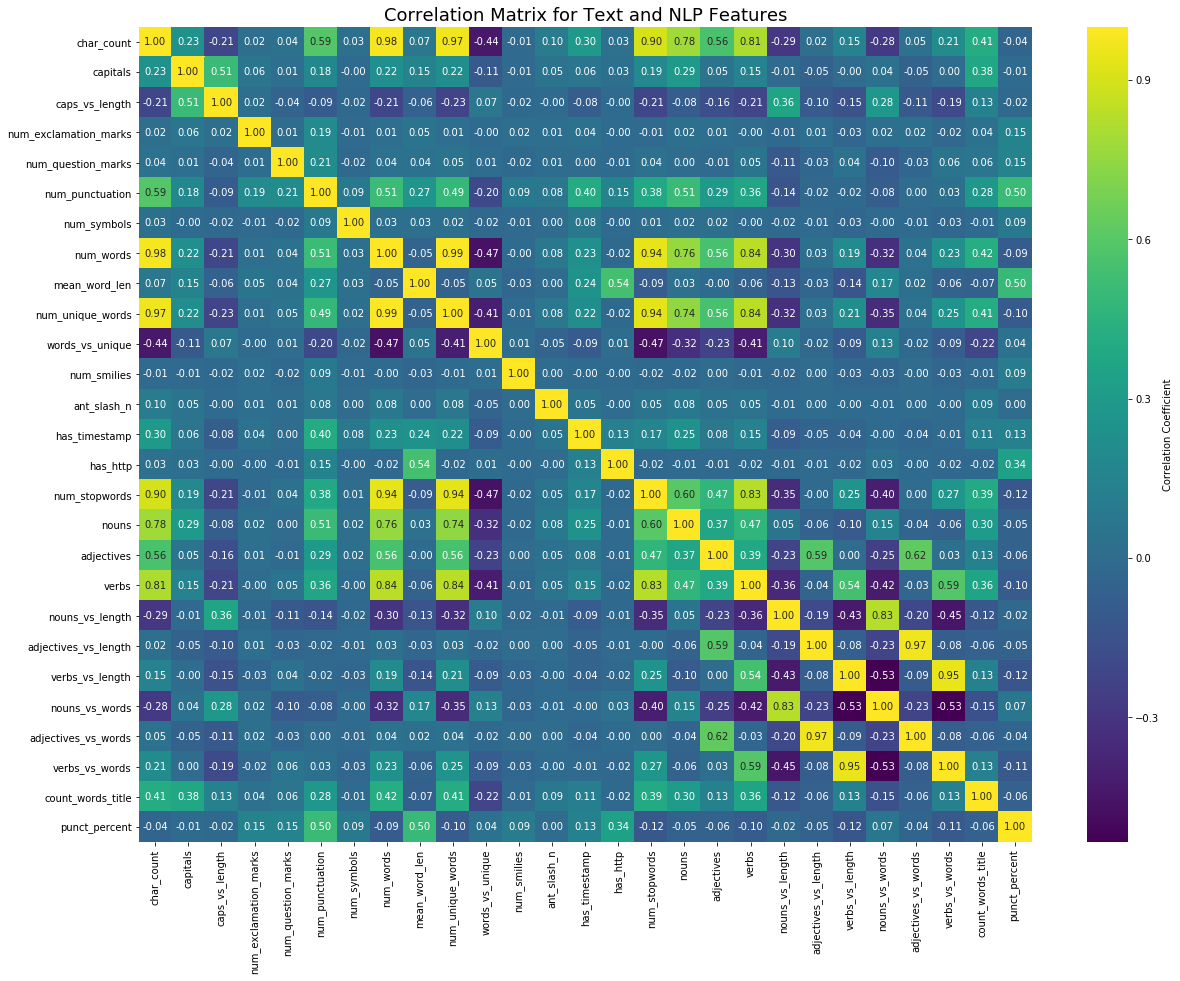

In [98]:
f, ax = plt.subplots(figsize= [20,15])

sns.heatmap(df.drop(['utterance'], axis=1).corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')


ax.set_title("Correlation Matrix for Text and NLP Features", fontsize=18)


AttributeError: module 'seaborn' has no attribute 'savefig'

### Let's see for example most common trigrams for positive phrases


In [60]:
counts = collections.Counter()

for sent in df['utterance']:
    words = nltk.word_tokenize(sent)
    counts.update(nltk.bigrams(words))

In [61]:
Bigram_Counts = counts.most_common(5)
Bigram_Counts

[(('I', "'m"), 962),
 (('do', "n't"), 584),
 (('it', "'s"), 576),
 (('I', "'ll"), 484),
 (('in', 'the'), 394)]

In [64]:
counts = collections.Counter()


for sent in df['utterance']:
    words = nltk.word_tokenize(sent)
    counts.update(nltk.trigrams(words))

In [65]:
Trigram_Counts = counts.most_common(5)
Trigram_Counts

[(('I', 'do', "n't"), 284),
 (('I', 'love', 'you'), 142),
 (('!', '!', '!'), 130),
 ((')', ')', ')'), 108),
 (('?', '?', '?'), 100)]

### Finally !! Loading embeddings


In [69]:
def load_embed(file):
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    if file == '../input/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
        
    return embeddings_index

In [70]:
os.chdir("/Users/dsg281/RahulData/Vectors/Vectors/embeddings/")

In [71]:
glove = 'Glove_Vectors/glove.840B.300d.txt'

paragram =  'paragram_300_sl999/paragram_300_sl999.txt'

fast_text = 'wiki-news-300d-1M/wiki-news-300d-1M.vec'


In [72]:
print("Extracting GloVe embedding",'\n')
embed_glove = load_embed(glove)

print("Extracting Paragram embedding",'\n')
embed_paragram = load_embed(paragram)

print("Extracting FastText embedding",'\n')
embed_fasttext = load_embed(fast_text)

Extracting GloVe embedding 

Extracting Paragram embedding 

Extracting FastText embedding 



## Your data vs glove vector 

In [73]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [74]:
def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [75]:
vocab = build_vocab(df['utterance'])


In [80]:
print("Glove : ")
oov_glove = check_coverage(vocab, embed_glove)
print("\n")

print("Paragram : ",'\n')
oov_paragram = check_coverage(vocab, embed_paragram)
print("\n")

print("FastText : ",'\n')
oov_fasttext = check_coverage(vocab, embed_fasttext)

Glove : 
Found embeddings for 65.93% of vocab
Found embeddings for  91.04% of all text


Paragram :  

Found embeddings for 53.76% of vocab
Found embeddings for  78.81% of all text


FastText :  

Found embeddings for 62.63% of vocab
Found embeddings for  87.77% of all text


In [81]:
## Check not Available words In Vectors

In [82]:
print("Glove vector analysis")

oov_glove[:5]

Glove vector analysis


[("i'm", 248), ("That's", 162), ("i'll", 136), (':(', 116), ("he's", 106)]

In [83]:
print("Paragram vector analysis")

oov_paragram[:5]

Paragram vector analysis


[('I', 4980), ("I'm", 960), ('Oh', 522), ("I'll", 484), ('And', 436)]

In [84]:
print("Paragram vector analysis")

oov_fasttext[:5]

Paragram vector analysis


[("I'm", 960), ("don't", 580), ("it's", 574), ("I'll", 484), ("that's", 306)]